# **Import and Install**

In [ ]:
import re
import math
import emoji
import string
import pickle
import collections
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification, AutoModelForTokenClassification, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from wordcloud import WordCloud

# **Dataset Preprocessing**

In [ ]:
df_1 = pd.read_json('../datasets/raw_datasets/amazon_one_plus_reviews.json')
df_2 = pd.read_csv('../datasets/raw_datasets/apple_iphone_11_reviews.csv')

In [ ]:
df_1['review_text'] = df_1['review_text'].str.replace('\n', '').str.strip()

In [ ]:
df = pd.concat([df_1, df_2])

In [ ]:
print(f'Before:\n{df.isnull().sum()}')
df.dropna(subset=['review_text'], inplace=True)
df.dropna(subset=['review_title'], inplace=True)
print()
print(f'After:\n{df.isnull().sum()}')

In [ ]:
df.to_csv('../datasets/final/merged_reviews.csv', index=False)

# **EDA**

In [ ]:
text = ''.join(df['review_text'].astype(str))
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white").generate_from_text(text)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
reviews = df['review_text']
all_words = []
for text in reviews:
  sentences = word_tokenize(str(text))
  words = [word for word in sentences if word not in string.punctuation]
  words = [word for word in words if word not in stopwords.words('english')]
  words = [word for word in words if word.isalpha()]
  all_words.extend(words)

word_freq = collections.Counter(all_words)
common_words = word_freq.most_common(20)
words, frequencies = zip(*common_words)

plt.bar(words, frequencies)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common and Words in Reviews')
plt.show()

# **Sentiment Analysis**

In [ ]:
sentiment_df = df

## **Data Labeling**

In [ ]:
def label_rating(review_rating):
  match = re.search(r'(\d+(\.\d+))\s*out of 5 stars', review_rating)
  if match:
    return float(match.group(1))
  else:
    return None

sentiment_df['numeric_rating'] = sentiment_df['review_rating'].apply(label_rating)
print(sentiment_df['numeric_rating'])


none_values = sentiment_df['numeric_rating'].isna()
none_count = none_values.sum()
print("None values: ", none_count)

0       3.0
1       1.0
2       5.0
3       1.0
4       5.0
       ... 
5005    4.0
5006    4.0
5007    5.0
5008    5.0
5009    5.0
Name: numeric_rating, Length: 5007, dtype: float64
None values:  0


In [ ]:
def apply_labels(numeric_rating):
  if numeric_rating < 3:
    label = 'bad'
  elif numeric_rating == 3:
    label = 'neutral'
  else:
    label = 'good'
  return label

sentiment_df['label'] = sentiment_df['numeric_rating'].apply(apply_labels)
print(sentiment_df['label'])

0       neutral
1           bad
2          good
3           bad
4          good
         ...   
5005       good
5006       good
5007       good
5008       good
5009       good
Name: label, Length: 5007, dtype: object


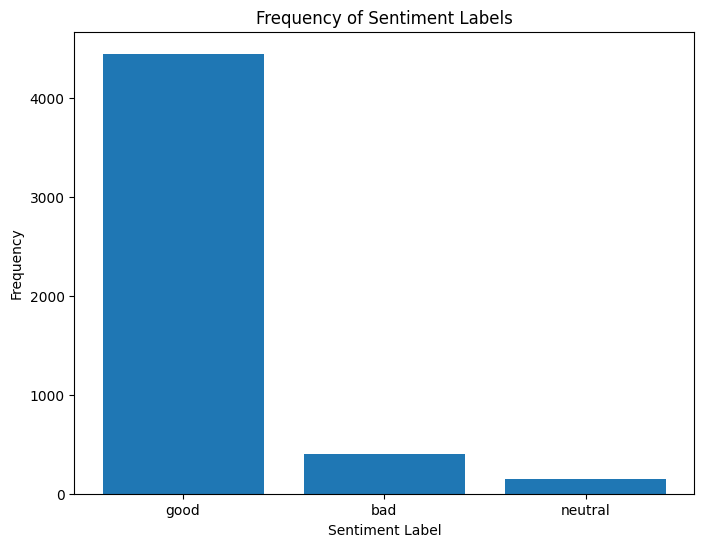

In [ ]:
label_counts = sentiment_df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Frequency of Sentiment Labels')
plt.show()

## **Data Resampling**

In [ ]:
neutral = sentiment_df[sentiment_df['label'] == 'neutral']
bad = sentiment_df[sentiment_df['label'] == 'bad']
good = sentiment_df[sentiment_df['label'] == 'good']

neutral_upsampled = neutral.sample(n=len(good), replace=True, random_state = 20)
bad_upsampled = bad.sample(n=len(good), replace=True, random_state = 20)

up_data = pd.concat([neutral_upsampled, bad_upsampled, good])

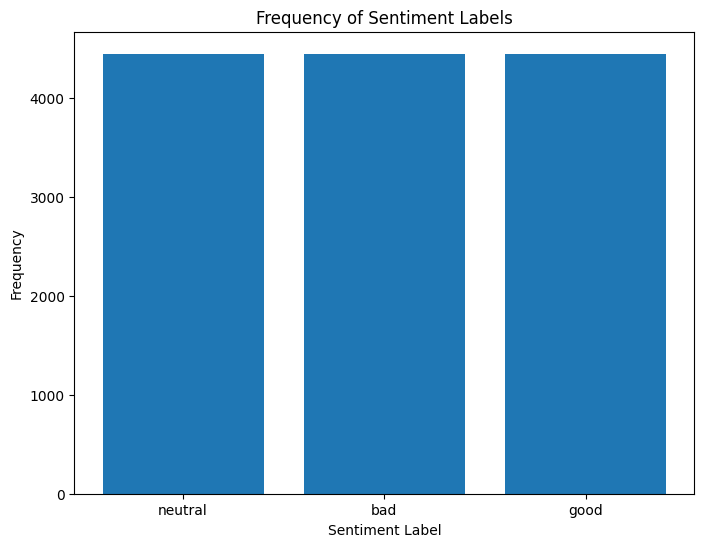

In [ ]:
label_counts = up_data['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Frequency of Sentiment Labels')
plt.show()

## **Train test split**

In [ ]:
train, eval = train_test_split(up_data,train_size=0.8,stratify=up_data['label'])

print(train)
print(eval)

      index                         product                  helpful_count  \
2033   2033  Apple iPhone XR (64GB) - Black                              0   
4199   4199  Apple iPhone XR (64GB) - Black                              0   
920     920  Apple iPhone XR (64GB) - Black                              0   
2587   2587  Apple iPhone XR (64GB) - Black                              0   
504     504  Apple iPhone XR (64GB) - Black  One person found this helpful   
...     ...                             ...                            ...   
4978   4978  Apple iPhone XR (64GB) - Black                              0   
1357   1357  Apple iPhone XR (64GB) - Black  One person found this helpful   
390     390  Apple iPhone XR (64GB) - Black    2 people found this helpful   
247     247  Apple iPhone XR (64GB) - Black                              0   
497     497  Apple iPhone XR (64GB) - Black  One person found this helpful   

                                            review_text       r

## **Training Model**

### **Tokenizing**

In [ ]:
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-cased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
train['review_text'] = train['review_text'].astype(str)
eval['review_text'] = eval['review_text'].astype(str)

label_mapping = {'bad': 0, 'neutral': 1, 'good': 2}

train['label'] = train['label'].map(label_mapping)
eval['label'] = eval['label'].map(label_mapping)

train_dataset = Dataset.from_pandas(train[['review_text', 'label']])
eval_dataset = Dataset.from_pandas(eval[['review_text', 'label']])

def tokenize_data(batch):
  tokenized_batch = tokenizer(batch['review_text'], padding='max_length', truncation=True, max_length=512)
  tokenized_batch['labels'] = batch['label']
  return tokenized_batch

train_dataset = train_dataset.map(tokenize_data, batched=True)
eval_dataset = eval_dataset.map(tokenize_data, batched=True)

print(train['label'].head())
print(eval['label'].head())
print(train_dataset[0])


Map:   0%|          | 0/10675 [00:00<?, ? examples/s]

Map:   0%|          | 0/2669 [00:00<?, ? examples/s]

2033    0
4199    1
920     2
2587    2
504     0
Name: label, dtype: int64
1845    0
3282    0
555     0
134     2
119     0
Name: label, dtype: int64
{'review_text': 'My phone is not working properly & I m not satisfy, its cheating done by seller & Amazon is not supporting', 'label': 0, '__index_level_0__': 2033, 'input_ids': [101, 1422, 2179, 1110, 1136, 1684, 7513, 111, 146, 182, 1136, 13692, 117, 1157, 18661, 1694, 1118, 18275, 111, 9786, 1110, 1136, 4374, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

In [ ]:
trainargs=TrainingArguments('tweet_sentiments_analysis_distilbert',
  num_train_epochs=5,
  evaluation_strategy="epoch",
  save_strategy='epoch',
  load_best_model_at_end=True,
  push_to_hub=False
)

### **Training**

In [ ]:
model_name = 'distilbert-base-cased'
num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

sentiment_analysis_model = Trainer(
  model=model,
  args=trainargs,
  train_dataset=train_dataset,
  eval_dataset=eval_dataset,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
)

sentiment_analysis_model.train()

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1-score
1,0.249200,0.122665,0.966614
2,0.091200,0.109506,0.973028
3,0.059100,0.115392,0.973364
4,0.038100,0.093448,0.975194
5,0.040800,0.091827,0.975189


TrainOutput(global_step=6675, training_loss=0.12260814502444607, metrics={'train_runtime': 2688.8565, 'train_samples_per_second': 19.85, 'train_steps_per_second': 2.482, 'total_flos': 7070573494656000.0, 'train_loss': 0.12260814502444607, 'epoch': 5.0})

## **Evaluation**

In [ ]:
results = sentiment_analysis_model.evaluate()
print("DistilBERT model:")
print("Evaluation results:", results)

DistilBERT model:
Evaluation results: {'eval_loss': 0.09182687848806381, 'eval_f1-score': 0.9751889560307472, 'eval_runtime': 42.362, 'eval_samples_per_second': 63.005, 'eval_steps_per_second': 7.884, 'epoch': 5.0}


In [ ]:
#masukin Save model


In [ ]:
#masukin prediction model

# **NER**

## **Function and Defined Variable**

In [ ]:
camera = ['image', 'picture', 'camera', 'video', 'photography', 'ois', 'eis', 'stabilization']
performance = ['faster', 'cpu', 'performance', 'lag', 'processor', 'power', 'smooth', 'os', 'specification', 'android', 'ios']
screen = ['screen', 'display', 'nits', 'brightness', 'ips', 'hz', 'hertz', 'lcd']
charging = ['charging', 'charge', 'watt', 'port', 'usb']
audio = ['mic', 'microphone', 'audio', 'speaker', 'volume', 'loudspeaker', 'headphone']
connection = ['connection', 'wifi', 'bluetooth']
storage = ['ram', 'rom', 'storage', 'emmc', 'ufs', 'mbps', 'gbps', 'microsd']
feature = ['feature', 'sensor', 'sensors', 'hdr']

In [ ]:
def to_iob_tag(data_1, data_2):
	arr = []
	for i, (cleaned_review, tag) in enumerate(zip(data_1, data_2)):
		review_tokenize = word_tokenize(cleaned_review)
		tag_tokenize = word_tokenize(tag)

		for (review_edit, tag_edit) in zip(review_tokenize, tag_tokenize):
			flag = f'Sentence {i + 1}'
			arr.append((flag, review_edit, tag_edit))

	tokenize_df = pd.DataFrame(arr)
	tokenize_df.rename(columns={0: 'Sentence #', 1: 'Word', 2: 'Tag'}, inplace=True)
	tokenize_df["Sentence #"] = LabelEncoder().fit_transform(tokenize_df["Sentence #"])
	tokenize_df.rename(columns={"Sentence #": "sentence_id", "Word": "words", "Tag": "labels"}, inplace =True)
	tokenize_df["labels"] = tokenize_df["labels"].str.upper()
	tokenize_df.dropna(inplace=True)

	return tokenize_df

In [ ]:
def tagging_cpu_data(text):
   text_dict = ''
   word_token = word_tokenize(text)
   
   for i in enumerate(word_token):
      if i == 0:
         text_dict = text_dict + 'B-performance '
      else:
         text_dict = text_dict + 'I-performance '
      
   return text_dict

In [ ]:
def tagging_data(text):
  word_token = word_tokenize(text)
  text_dict = ['O'] * len(word_token)

  for i, word in enumerate(word_token):
    word = word.lower()
    if text_dict[i] != 'O':
      continue
    if word in camera:
      text_dict[i] = 'B-camera'
    elif word in performance:
      text_dict[i] = 'B-performance'
    elif word in screen:
      text_dict[i] = 'B-screen'
    elif word in charging:
      text_dict[i] = 'B-charging'
    elif word in audio:
      if re.match(r'\b(audio|headphone)\b', word, re.IGNORECASE) and i < len(word_token) - 1 and word_token[i + 1] == 'jack':
        text_dict[i] = 'B-audio'
        text_dict[i + 1] = 'I-audio'
      else:
        text_dict[i] = 'B-audio'
    elif word in connection:
      text_dict[i] = 'B-connection'
    elif word in storage:
      text_dict[i] = 'B-storage'
    elif word in feature:
      text_dict[i] = 'B-feature'
    elif word in cpu_b_name_word:
      text_dict[i] = 'B-performance'
    elif word in cpu_i_name_word and (text_dict[i - 1] == 'B-performance' or text_dict[i - 1] == 'I-performance'):
      text_dict[i] = 'I-performance'
    else:
      if re.match(r'\b\d+(?:gb|mb|kb)\b', word, re.IGNORECASE):
        text_dict[i] = 'B-storage'
        if i < len(word_token) - 1 and re.match(r'\b(ram|rom)\b', word_token[i + 1], re.IGNORECASE):
          text_dict[i + 1] = 'I-storage'
      elif re.match(r'\b(amoled|oled)\b', word, re.IGNORECASE):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and re.match(r'\b(display|screen)\b', word_token[i + 1], re.IGNORECASE):
          text_dict[i + 1] = 'I-screen'
      elif re.match(r'\b\d+\-*(?:mp|megapixel)\b', word, re.IGNORECASE):
        text_dict[i] = 'B-camera'
      elif re.match(r'\b\d+(?:hz|hertz|p)\b', word, re.IGNORECASE):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and re.match(r'\b(resolution|refresh)\b', word_token[i + 1], re.IGNORECASE):
          text_dict[i + 1] = 'I-screen'
          if i + 2 < len(word_token) - 1 and re.match(r'\brate\b', word_token[i + 2], re.IGNORECASE):
            text_dict[i + 2] = 'I-screen'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(gb|mb|kb)\b', word_token[i + 1], re.IGNORECASE):
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(ram|rom)\b', word_token[i + 2], re.IGNORECASE):
          text_dict[i + 2] = 'I-storage'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(mp|megapixels?)\b', word_token[i + 1], re.IGNORECASE):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(systems?|sensors?)\b', word_token[i + 2], re.IGNORECASE):
          text_dict[i + 2] = 'I-camera'
      elif word == 'fingerprint' and i < len(word_token) - 1 and re.match(r'\b(scanner|reader)\b', word_token[i + 1], re.IGNORECASE):
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'face' and i < len(word_token) - 1 and re.match(r'\b(unlock|id)\b', word_token[i + 1], re.IGNORECASE):
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'sd' and i < len(word_token) - 1 and word_token[i + 1] == 'card':
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
      elif word == 'micro' and i < len(word_token) - 1 and word_token[i + 1] == 'sd':
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
      elif re.match(r'\b(macro|main|front|ultrawide|wide|zoom|rear|selfie|depth|telephoto)\b', word, re.IGNORECASE) and i < len(word_token) - 1 and re.match(r'\bcameras?\b', word_token[i + 1], re.IGNORECASE):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(systems?|sensors?)\b', word_token[i + 2], re.IGNORECASE):
          text_dict[i + 2] = 'I-camera'
      elif i < len(word_token) - 1 and re.match(r'\b(cameras?)\b', word, re.IGNORECASE) and re.match(r'\bsensors?\b', word_token[i + 1], re.IGNORECASE):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
      elif word == 'operating' and i < len(word_token) - 1 and word_token[i + 1] == 'system':
        text_dict[i] = 'B-performance'
        text_dict[i + 1] = 'I-performance'
      elif re.match(r'\b(proximity|accelerometer|gyroscope|barometer|biometrics)\b', word, re.IGNORECASE):
        text_dict[i] = 'B-feature'
        if i < len(word_token) - 1 and re.match(r'\bsensors?\b', word_token[i + 1], re.IGNORECASE):
          text_dict[i + 1] = 'I-feature'
      elif re.match(r'\b(augmented|virtual)\b', word, re.IGNORECASE) and i < len(word_token) - 1 and word_token[i + 1] == 'reality':
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'battery': 
        text_dict[i] = 'B-battery'
        if i < len(word_token) - 1 and re.match(r'\b(capacity|life)\b', word_token[i + 1], re.IGNORECASE):
          text_dict[i + 1] = 'I-battery'
      elif re.match(r'\b\d+mah\b', word, re.IGNORECASE):
        text_dict[i] = 'B-battery'
      elif word.isnumeric() and i < len(word_token) - 1 and word_token[i + 1] == 'mah':
        text_dict[i] = 'B-battery'
        text_dict[i + 1] = 'I-battery'
      elif word == 'button':
        text_dict[i] = 'B-button'
        if re.match(r'\b(power|volume|lock|mute|home|back)\b', word_token[i - 1], re.IGNORECASE):
          text_dict[i] = 'I-button'
          text_dict[i - 1] = 'B-button'
      elif word == 'connectivity':
        text_dict[i - 1] = 'B-connection'
        text_dict[i] = 'I-connection'
      elif re.match(r'\b\dg\b', word, re.IGNORECASE):
        text_dict[i] = 'B-connection'
        if i < len(word_token) - 1 and re.match(r'\b(connectivity|network)\b', word_token[i + 1], re.IGNORECASE):
          text_dict[i + 1] = 'I-connection'
      elif word == 'network':
        text_dict[i] = 'B-connection'
        if word_token[i - 1] == 'mobile':
          text_dict[i - 1] = 'B-connection'
          text_dict[i] = 'I-connection'
      elif re.match(r'\b(f|q)?hd\b', word, re.IGNORECASE):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and word_token[i + 1] == 'display':
          text_dict[i + 1] = 'I-screen'
      elif re.match(r'\b\d+\-*ppi\b', word, re.IGNORECASE):
        text_dict[i] = 'B-screen'
      elif word.isnumeric() and i < len(word_token) - 1 and word_token[i + 1] == 'ppi':
        text_dict[i] = 'B-screen'
        text_dict[i + 1] = 'I-screen'
      elif re.match(r'\bip6\d\b', word, re.IGNORECASE):
        text_dict[i] = 'B-feature'
        if i < len(word_token) - 1 and word_token[i + 1] == 'rating':
          text_dict[i + 1] = 'I-feature'
      elif re.match(r'\b\d+(?:watt|w)\b', word, re.IGNORECASE):
        text_dict[i] = 'B-charging'
        if i < len(word_token) - 1 and re.match(r'\b(charge|charging|charger)\b', word_token[i + 1], re.IGNORECASE):
          text_dict[i + 1] = 'I-charging'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(watt|w)\b', word_token[i + 1], re.IGNORECASE):
        text_dict[i] = 'B-charging'
        text_dict[i + 1] = 'I-charging'
      elif re.match(r'\b(fast|quick)\b', word, re.IGNORECASE) and i < len(word_token) - 1 and re.match(r'\b(charge|charging|charger)\b', word_token[i + 1], re.IGNORECASE):
        text_dict[i] = 'B-charging'
        text_dict[i + 1] = 'I-charging'

  tokenized_text = ' '.join(text_dict)
  return tokenized_text

## **Datasets for CPU Name**

In [ ]:
data = pd.DataFrame({'cpu_name': ['A10 Fusion',
'A11 Bionic',
'A12 Bionic',
'A13 Bionic',
'A14 Bionic',
'A15 Bionic',
'A16 Bionic',
'A17 Pro',
'Apple A9',
'Dimensity 1000 Plus',
'Dimensity 1050',
'Dimensity 1080',
'Dimensity 1100',
'Dimensity 1200',
'Dimensity 1300',
'Dimensity 6020',
'Dimensity 6080',
'Dimensity 6100 Plus',
'Dimensity 6300',
'Dimensity 700',
'Dimensity 7020',
'Dimensity 7025',
'Dimensity 7030',
'Dimensity 7050',
'Dimensity 720',
'Dimensity 7200',
'Dimensity 7200 Ultra',
'Dimensity 800',
'Dimensity 800U',
'Dimensity 8020',
'Dimensity 8050',
'Dimensity 810',
'Dimensity 8100',
'Dimensity 820',
'Dimensity 8200',
'Dimensity 8300',
'Dimensity 900',
'Dimensity 9000',
'Dimensity 9000 Plus',
'Dimensity 920',
'Dimensity 9200',
'Dimensity 9200 Plus',
'Dimensity 930',
'Dimensity 9300',
'Exynos 1280',
'Exynos 1330',
'Exynos 1380',
'Exynos 1480',
'Exynos 2100',
'Exynos 2200',
'Exynos 2400',
'Exynos 7870',
'Exynos 7884B',
'Exynos 7885',
'Exynos 7904',
'Exynos 850',
'Exynos 8890',
'Exynos 8895',
'Exynos 9610',
'Exynos 9611',
'Exynos 980',
'Exynos 9810',
'Exynos 9820',
'Exynos 9825',
'Exynos 990',
'Google Tensor',
'Helio A22',
'Helio G25',
'Helio G35',
'Helio G36',
'Helio G37',
'Helio G70',
'Helio G80',
'Helio G85',
'Helio G88',
'Helio G90T',
'Helio G95',
'Helio G96',
'Helio G99',
'Helio P22',
'Helio P35',
'Helio P60',
'Helio P65',
'Helio P70',
'Helio P90',
'Helio P95',
'Kirin 659',
'Kirin 710',
'Kirin 710A',
'Kirin 710F',
'Kirin 810',
'Kirin 9000',
'Kirin 9000S',
'Kirin 9010',
'Kirin 960',
'Kirin 970',
'Kirin 980',
'Kirin 990 (5G)',
'MediaTek MT6737',
'Snapdragon 4 Gen 1',
'Snapdragon 4 Gen 2',
'Snapdragon 430',
'Snapdragon 435',
'Snapdragon 439',
'Snapdragon 450',
'Snapdragon 460',
'Snapdragon 480',
'Snapdragon 480 Plus',
'Snapdragon 6 Gen 1',
'Snapdragon 625',
'Snapdragon 630',
'Snapdragon 632',
'Snapdragon 636',
'Snapdragon 660',
'Snapdragon 662',
'Snapdragon 665',
'Snapdragon 670',
'Snapdragon 675',
'Snapdragon 678',
'Snapdragon 680',
'Snapdragon 685',
'Snapdragon 690',
'Snapdragon 695',
'Snapdragon 7 Gen 1',
'Snapdragon 7 Gen 3',
'Snapdragon 7 Plus Gen 2',
'Snapdragon 7 Plus Gen 3',
'Snapdragon 710',
'Snapdragon 712',
'Snapdragon 720G',
'Snapdragon 730',
'Snapdragon 730G',
'Snapdragon 732G',
'Snapdragon 750G',
'Snapdragon 765G',
'Snapdragon 778G',
'Snapdragon 778G Plus',
'Snapdragon 780G',
'Snapdragon 782G',
'Snapdragon 7s Gen 2',
'Snapdragon 8 Gen 1',
'Snapdragon 8 Gen 2',
'Snapdragon 8 Gen 3',
'Snapdragon 8 Plus Gen 1',
'Snapdragon 820',
'Snapdragon 821',
'Snapdragon 835',
'Snapdragon 845',
'Snapdragon 855',
'Snapdragon 855 Plus',
'Snapdragon 860',
'Snapdragon 865',
'Snapdragon 865 Plus',
'Snapdragon 870',
'Snapdragon 888',
'Snapdragon 888 Plus',
'Snapdragon 8s Gen 3',
'Tensor G2',
'Tensor G3',
'Tiger T610',
'Tiger T612',
'Tiger T616',
'Tiger T618',
'Tiger T700',
'Unisoc SC9863A',
'Unisoc T606',
'Unisoc T820']})

In [ ]:
data.to_csv('../datasets/raw_datasets/cpu_name.csv', index=False)

## **CPU Name**

In [ ]:
cpu = pd.read_csv('datasets/raw_datasets/cpu_name.csv', encoding='latin1')

In [ ]:
cpu = pd.DataFrame({'cpu_name': cpu['cpuName']})
cpu.head()

In [ ]:
cpu.dropna(inplace=True)
len(cpu)

355

In [ ]:
cpu = cpu.drop_duplicates()
len(cpu)

230

In [ ]:
cpu = cpu.drop(cpu.index[[71]])
cpu

,cpu_name
0,A15 Bionic
3,M1
7,A14 Bionic
12,Tensor
14,A13 Bionic
...,...
162,Tiger T618
163,Tiger T700
164,Unisoc SC9863A
165,Unisoc T606


In [ ]:
cpu['tag'] = cpu['cpu'].apply(tagging_cpu_data)
cpu = cpu.sample(frac=1)
cpu.head()

,cpu_name,tag
150,Snapdragon 860,B-performance I-performance
14,A13 Bionic,B-performance I-performance
165,Exynos 9611,B-performance I-performance
93,Kirin 9000,B-performance I-performance
33,Dimensity 820,B-performance I-performance


In [ ]:
cpu_tag = to_iob_tag(cpu['cpu_name'], cpu['tag'])
cpu_tag.to_csv('..datasets/tagged/cpu-iob-tag.csv')

## **Tagging Dataset**

In [ ]:
cpu_name = pd.read_csv('../datasets/tagged/cpu-iob-tag.csv')
cpu_name.head()

,sentence_id,words,labels
0,0,snapdragon,B-PERFORMANCE
1,0,860,I-PERFORMANCE
2,111,a13,B-PERFORMANCE
3,111,bionic,I-PERFORMANCE
4,152,exynos,B-PERFORMANCE


In [ ]:
cpu_b_tag = cpu_name.loc[cpu_name['labels'] == 'B-PERFORMANCE']
cpu_i_tag = cpu_name.loc[cpu_name['labels'] == 'I-PERFORMANCE']

cpu_b_name_word = set(cpu_b_tag['words'].tolist())
cpu_b_name_word = list(cpu_b_name_word)
cpu_b_name_word = [i.lower() for i in cpu_b_name_word]
cpu_b_name_word.remove('Google')
						 
cpu_i_name_word = set(cpu_i_tag['words'].tolist())
cpu_i_name_word = list(cpu_i_name_word)
cpu_i_name_word = [i.lower() for i in cpu_i_name_word]
cpu_i_name_word.remove('Tensor')

In [ ]:
new_df = pd.DataFrame({'review': df['review_text']})
new_df.head()

,review
0,"Yea..pre-ordered on 28 July, got it on 4 Augus..."
1,"Got it delivered yesterday , used for about 5-..."
2,An amazing phone!
3,Brilliant..
4,I was skeptical about changing from One plus 6...


### **More data and resampling**

In [ ]:
# Data from GSMArena
gsm_arena_review = [
	'''Huawei Pura 70 Ultra is the headliner of the reimagined Photography series by Huawei. It packs the best camera the Chinese maker could conjure up, coupled with the best design, screen, Kirin chipset, and battery technology, of course.''',
	'''Despite the name change, the Huawei P series is alive and kicking, promising as ever, even without Leica or other trendy partnership being present for marketing hype. And, yes, the US sanctions are still at play, but Huawei seems to be on the verge of making those irrelevant.''',
	'''Back to what we do best - smartphone inspection - we are nothing short of thrilled by our time spent with the Huawei Pura 70 Ultra. And while we are in the process of reviewing it, we decided to give you a glimpse of what's coming your way.''',
	'''The Pura 70 Ultra is one of the few phones on the market you can immediately pick among a hundred phones in a second. The triangular camera design and unique back panel are quite nice, even if the housing is, well, huge.''',
	'''Then we have a large 6.8-inch LTPO OLED screen of 1260p resolution, 1B colors and 120Hz refresh rate. The Kirin 9010 chipset with 5G connectivity will probably initiate a new portion of investigations, but it does look promising with improved capabilities.''',
	'''The camera is the real showstopper here and rightfully, so. The retractable main camera is thoroughly interesting with its unique mechanical design, sure, but we cannot wait to test its 1" sensor, one that makes use of sensor-shift stabilization, variable aperture lens and laser-assisted AF. Next is a 50MP telephoto camera for 3.5x optical zoom and up to 10x hybrid zoom, one that can do macro photos from as close as 5cm away! The 40MP ultrawide camera promises really wide field of view with its 13mm aperture lens, and it is AF-capable.''',
	'''The 13MP selfie camera also has wide-angle lens supports autofocus, too.''',
	'''Finally, the Huawei Pura 70 Ultra packs a 5200mAh battery capable of 100W wired and 80W wireless charging, plus 20W reverse wireless charging!''',
	'''The Pura 70 Ultra ships into one large and thick luxury-looking box. Inside you will find the phone itself, one premium case with a matching color but a different P-styled texture, a 100W power adapter and a USB cable.''',
	'''Notice the charger has both USB-C and USB-A ports, though it is not a dual-charger - you can use one of those at a time.''',
	'''The Honor and Porsche Design design collaboration continues and after the Magic V2 RSR we now have the Magic6 RSR. This one is a reimagined Magic6 Pro that  comes with a couple of hard to spot hardware improvements - in contrast to the V2 situation where the differences were skin-deep.''',
	'''The Porsche Design Magic6 RSR builds on the regular model's camera system by adding some extra autofocusing assistance. It comes in the form of a 1200-point LiDAR matrix that enables focusing speeds at up to 60fps. Great for pet photo shoots then. ''',
	'''Honor also says it's using a different and more advanced version of the primary camera's sensor that pushes its dynamic range capability up to 15EV. The weather contributed with clouds for that test.''',
	'''The display is also different on the Magic6 RSR, compared to the Magic6 Pro. The size and resolution are unchanged, but it's now a dual-layer OLED panel - or Tandem display - promising improved longevity and a nudge in max brightness (not that the non-RSR version was lacking in that respect).''',
	'''We'll have a look at the Porsche Design Honor Magic6 RSR and compare it side by side with the regular version, focusing on the differences mentioned - sort of a mini-review of the display and its effect on battery life, and a brief exploration into the main camera and how it stacks up next to that of the Magic6 Pro.''',
	'''The presentation of the Porsche Design version is predictably more upscale than that of the regular Magic6 Pro. The contrast is now even more stark than it would have been in previous years, with the Pro switching to the phone-only approach in 2024 - not so with the RSR.''',
	'''The Porsche Design Magic6 ships in an oversized graphite colored box that does contain more than you'd normally expect. The most surprising development (if you haven't already seen the Magic V2 RSR unboxing) is the inclusion of not one, but two, separate chargers - one with a UK style plug (Type G) and another with a Euro plug (Type F). There's also a separate cable for each adapter. Maybe all the chargers saved from mainstream Magics have been diverted to RSR boxes.''',
	'''The package also includes a snap-on protective case for the back of the phone. It's covered in a leather-like material on the outside, which looks just like that on the Magic V2 RSR's case, but is somehow ever so slightly less supple. It's still pretty nice, of course, it's just that the other one is nicer. On the inside, the alcantara or similar material has a fine pattern of hexagons, just like the phone's camera island.'''
	'''It's been a while now since we originally saw the Honor Magic V2 and got our initial hands-on experience at the Chinese announcement event. Since then, the phone finally had its global launch alongside an RSR Porsche Design edition. It's almost May now, and we finally we finally get an opportunity to review both devices. We are only pointing out the timeframe of things since, in today's dynamic market, all that time is more than enough to make a phone not necessarily irrelevant but definitely less exciting.</p>''',
	'''But not the Honor Magic V2, though. It remains special, like really special, for both foldable fans and the smartphone realm in general. Sure, it might be running a generation-old Snapdragon 8 Gen 2 chipset at this point, but that's about the only non-current and non-revolutionary thing about the Magic V2.</p>''',
	'''Let's start with what is probably the most impressive aspect of the Magic V2 - its size and weight. Of course, in absolute terms, it is far from compact, measuring 156.7x74.1x9.9mm folded and tipping the scale at 231g (with a few asterisks). It may not sound <i>that</i> impressive until you realize that Honor has made the first foldable in this form factor with a less than 10mm thickness.</p>''',
	'''And if that's not impressive enough, consider that the non-folding Samsung Galaxy S24 Ultra measures 162.3 x 79 x 8.6 mm and weighs in at 232 grams. With the V2, you can now get a whole extra display (and a large 7.92-inch one at that) and no other major compromises, including a hefty 5,000 mAh battery a potent triple camera setup and even an extra selfie camera all in roughly the same form factor as Samsung's or Apple's current flagship models. Foldables really have come a long way, and despite its relative age, the Honor Magic V2 represents the current pinnacle of this form factor.</p>''',
	'''It almost feels like Honor broke some laws of physics with the Magic V2. A lot of the space and weight savings come from the new silicon-carbon battery used in the Magic V2. It boasts impressive energy density, making it super thin, which explains how you can get that capacity inside a svelte body like the Magic V2's.</p>''',
	'''There are many more refinements and upgrades in the Magic V2, which is technically the third major iteration in Honor's foldable line. We'll definitely go over everything in detail, but some highlights include the 120Hz refresh rate on the foldable display and LTPO tech on both panels plus a brand new camera setup with OIS and 8x8 dToF Laser AF on the main cam.</p>''',
	'''We'll also mention that while we were trying to fit the V2 in the hectic review schedule, a package arrived at our doorstep with another V2, a v2 of the V2, so to speak. The Porsche Design Honor Magic V2 RSR is a much more exclusive repackaging of otherwise the same hardware, and we'll say a few words on that one as well.</p>''',
	'''Unlike most mainstream flagships, foldables still tend to present themselves as more premium products. Hence, you can usually expect more attention to the retail bundle like back in the day. This is definitely true for the Magic V2. It comes in a large and very posh-feeling box that provides plenty of protection during shipping.</p>''',
	'''The accessory package is quite lavish, especially in modern terms. You get one of Honor's 66W SuperCharge adapters in the box which pairs perfectly with the charging capabilities of the phone. Interestingly enough, the charger still uses a Type-A connection, which is why you get a Type-A to Type-C USB cable in the box. Also included is a snap-on case with a carbon fiber pattern as well as a kickstand.</p>''',
	'''And if you thought that was premium, wait till you see the Porsche Design version. An even nicer box is just the start, but the contents do go the extra mile.</p>''',
	'''For one, you get not one, but two chargers, one with a UK style plug (Type G) and another with a Euro plug (Type F) - because if you can afford the RSR version, you clearly are a globetrotter that can't be bothered with socket adapters. You also get two USB cables, because at this point, why not?</p>''',
	'''The bundle includes an even nicer back cover that's clad in what is either real leather or looks and feels very close to it, plus it has real thread stitching. ''',
	'''Both Magic V2s can be operated with a stylus, but only the Porsche Design version comes with one in the box. And it's a pretty fancy-looking one too, as befitting the brand, plus it comes with a carrying case of its own. Life of the rich and the famous, indeed.</p>''',
	'''Unintuitively, the Honor Pad 9 (a.k.a. the Tablet 9 in China) is has a large 12.1-inch screen. It covers all the basics with an eight-speaker audio setup and even stylus support, all for a fairly reasonable price of £299.99 or £349.99 with the optional Bluetooth keyboard attachment.'''
	'''The Pad 9 does not stray past the basics. There is no expandable storage, no 3.5mm audio jack, no support for positioning, and no NFC or a radio receiver. The camera setup is also fairly basic, with a 13MP snapper on the back and an 8MP one on the front.'''
	'''Then again, with the recent surge in "value-driving" devices in the tablet space, we have to assume that market research likely indicates that few users are looking for truly premium tablets, so the Honor Pad 9 might be well positioned in the midrange.'''
	'''The Honor Pad 9 ships in a basic two-piece cardboard box. There is no plastic in the package, which is always appreciated from an ecological standpoi'''
	'''The box cover has a large, to-scale image on the front of the tablet itself, along with the proud proclamation that it supports "the Google App and Google Chrome".'''
	'''There is plenty of space inside the box, and quite a few compartments for different accessories. Our unit only came with an Honor SuperCharge charger and a basic USB Type-A to Type-C cable. You don't get the keyboard or the stylus in the main box.'''
	'''We also got the optional Bluetooth keyboard in for review as well. It comes in an equally basic flip-up cardboard box with no plastics in sight. However, there is some foam to keep the keyboard from banging up against itself (in the case part).'''
	'''Unfortunately, we don't have the optional Honor Choice Pencil stylus to review at this time.''',
	'''Motorola is all about sensorial experiences this year and shifting the attention from specs to lifestyle - or at least that's the idea they're trying to sell us on with the Edge 50 Pro. Colors, materials, experiences, and AI are where the marketing focus is, but we'll try to remain pragmatic and not get too tangled in the esoteric.''',
	'''You can't miss the Pantone collaboration on the outside - as with previous models from the company, the Edge 50 Pro comes in at least one unusual hue that's been okayed by the color matching specialists; it's Luxe Lavender in this case. But that's been done before, and there's more Pantone now - the display and camera are Pantone-validated too, both of which are firsts in the industry (for whatever that's worth).''',
	'''More to our liking are numbers in general and the 6.7-inch OLED is both sharp (1220p) and fast (144Hz), not to mention bright (2000nits, Motorola says). There are specs to be appreciated in the camera field too - first and foremost, the f/1.4 aperture on the main camera. It's also nice to see a proper three-camera setup, telephoto included, and the fact that the ultrawide has autofocus deserves praise right from the outset.''',
	'''We're less enthusiastic about the heart of the Edge 50 Pro, the Snapdragon 7 Gen 3. Perhaps you recall that the Edge 40 Pro had the flagship Snapdragon last year, but this year's Pro is different - a restructuring of the lineup in 2024 means there's an Ultra at the top, like there was one generation prior, and that one gets the top-level chipset. The Pro, meanwhile, steps down to more of an upper-midrange status - we'll see where it stands on the value meter as we go along.''',
	'''The charging capability is about as flagship-grade as they come, though - at 125W and 18 minutes from empty to full, the specs are more than promising - albeit with some caveats. The 50W wireless charging rating is also a welcome improvement over the 15W of the previous generation, even if the 4,500mAh capacity isn't overly generous. We do like the relatively compact size and pocket-friendly weight, and the IP68 rating is most welcome too (also, befitting the 'Pro' moniker).''',
	'''Motorola unboxings have become somewhat of a treat in recent years, thanks to the company's practice of using fragrance on the inside of the box - that sure is 'a unique sensorial experience' that you won't be getting from other brands. We'll be quick to admit that there's little practical benefit to this, but that doesn't mean we like it any less. That's in addition to the packaging being plastic-free and made of 80% recycled materials, which is always nice.''',
	'''Inside, in addition to the phone, you'll be getting a TurboPower adapter. Its maximum output will vary depending on region and/or version of the phone. Our 12GB/512GB Euro spec includes the 125W charger, and that's what the 12GB/256GB option will also be getting, but the 8GB/128GB and 8GB/256GB variants will be bundled with a 68W unit (at least as best as we can tell - it's worth double checking with your vendor). A USB-C cable is included too.''',
	'''Also part of the package is a snap-on back cover with a semi-transparent frosted effect. The color of this accessory will be matched to the phone's colorway and for our Luxe Lavender review unit the hue is called Blue Heron (in Pantone speak again).''',
	'''The success of the Galaxy A54 has set the bar high for the just-released Galaxy A55. After the Samsung Galaxy S and Z foldable series, the Galaxy A5x series is likely the most popular in the company's portfolio for good reason. ''',
	'''This year's model makes gains in key areas. The new A55 boasts a bigger display, a more powerful chipset, more RAM in the base configuration and a tougher and more premium build.''',
	'''Most other aspects of what made the Galaxy A54 successful remain untouched - the microSD card support, good primary camera garnished with a decent ultrawide shooter, dependable battery life and IP67-rated build. Moreover, this time, it uses an aluminum frame and Gorilla Glass Victus+ protection.''',
	'''But will this be enough to persuade potential buyers? After all, the sub-€500 competition in Europe is fierce, and the same goes for the Indian INR 40,000-ish bracket. What made the A54 good in 2023 doesn't necessarily mean it will be enough in 2024. The competition is catching up, and we've seen some pretty solid midrangers come out in the first quarter of this year, so stick around to see if the A55 is worth your hard-earned money.''',
	'''The Galaxy A55 comes in a modest retail box with only some user manuals, a SIM tool and a USB-C to USB-C cable for charging and data transfer. There's no charger included.''',
	'''A few small but meaningful upgrades to the camera system, tweaks to the build and display, and the mandatory chipset refresh - we can't be mad at the Xiaomi 14 Ultra for its short list of changes, when last year's model was already one of the best cameraphones in existence.''',
	'''Indeed, the 14 Ultra doesn't stray too far from its predecessor. The main camera had a 1-inch sensor and dual-aperture lens on the 2023 model, the 2024 one uses a newer 1-inch sensor and makes that a truly variable aperture (with intermediate steps). The zoom cameras (two of them, as seemingly required to be called an Ultra), meanwhile, bring close focusing to the table and the longer of them also gets a slightly brighter lens.''',
	'''On the outside, Xiaomi has replaced the Corning-branded glass of the old model with an in-house concoction that should be more durable (asterisks, of course), and the <i>non-leather</i> leather has also been improved. There's a new aluminum alloy used for the frame in the International version, while China also gets a titanium option on top of that. Sounds like a win.''',
	'''Improvements in the display section are hard to spot, but there's a promise for slightly more brightness (hardly a gamechanger), while the new Snapdragon is the new Snapdragon - better than the old one, more or less the same across all 2024 mode''',
	'''Xiaomi has chosen not to mess around with battery capacity or charging speed on the global variant (Chinese version does get an extra 300mAh), and we think we could have used a bump in longevity - maybe we'll get that from elsewhere.''',
	'''Little has changed in the presentation and the 14 Ultra comes in the usual black thick cardboard box with simple Xiaomi lettering and a red Leica badge to add a splash of color. The internal packaging is all made of paper, so that's a win.''',
	'''The contents include a 90W charger (same as last year's) and a proprietary USB-A-to-C cable to go with it. Xiaomi has also bundled a translucent plastic snap-on back cover to protect the Ultra out of the box. It's on the cheap side, but something is better than nothing, plus the phone itself is supposedly more durable than the previous iteration. Let's see what that's about.''',
	'''Samsung has unveiled the new members of the Galaxy A series hot on the heels of the Galaxy S24 premiere. The Galaxy A35 and Galaxy A55 build on the positive reception of the previous models and bring updated designs, performance, and cameras. Today, we will explore the Galaxy A35 in detail.''',
	'''The new Samsung Galaxy A35 looks a lot like the Galaxy A34. As you can imagine, there are only a handful of upgrades, and they were not meant to tempt the Galaxy A34 owners to switch but more to lure new or existing Samsung users with much older phones.''',
	'''So, the Galaxy A35 starts with a new, updated dual-glass design and a more durable Gorilla Glass Victus+ front panel. The phone is IP67-rated for dust and water resistance and comes in a variety of catchy colors. The screen remains the same as on the Galaxy A34 - a 6.6-inch Super AMOLED of extended 1080p resolution and 120Hz refresh rate.''',
	'''The Galaxy A35 brings the same chipset we saw on the Galaxy A54 - the Exynos 1380 5G, so in a way, it can be a good alternative to the A54.''',
	'''The cameras haven't changed much since the Galaxy A34 - a high-res main camera, an 8MP ultrawide, a 5MP macro, and a 13MP selfie. There is a new primary, though, a 50MP OIS imager up from 48MP on the A34.''',
	'''Another new feature available on the Galaxy A35 is the support for Wi-Fi 6 networks.''',
	'''The Galaxy A34 is powered by a 5,000mAh with 25W fast charging support. It runs on Android 14 with One UI 6.1.''',
	'''The Galaxy A34 has a well-rounded specs sheet and no obvious omissions. However, it's very close to the Galaxy A54 feature set, so it remains to be seen if there is enough to set this new model apart. ''',
	'''The thin and lightweight cardboard retail box of the Galaxy A35 contains the phone and one basic passive 3A USB Type-C to Type-C cable. That's it. There are no plastics in sight, just cardboard.''',
	'''The Galaxy A35 supports 25W fast wired charging, but if you don't own a compatible USB-PD power adapter, you will need to shop for one, as there is no charger in the box.''',
	'''You look at the Galaxy S24 and S24+ and can't help but wonder if they really are the new models, or Samsung just went and reissued the old ones. The Ultra, on the other hand, is a different beast. The Galaxy S24 Ultra does make some significant strides towards improving on what was already the ultimate smartphone package.''',
	'''Some of the changes are immediately visible and start with the even blockier design with a fully flat face and the less reflective display glass. You won't immediately tell, but that glass should also be tougher, and as months go by, you'll perhaps appreciate the switch to titanium for the exposed frame, too.''',
	'''An even less obvious development, but one that has potential to be a major step in solidifying the Galaxy Ultra's position as a top cameraphone, is the new 5x zoom telephoto. Undoubtedly better at 5x than the old model, can it be as good at 10x?''',
	'''The Ultra won't partake in the chipset divide that's now returned to the lesser models, and all of the ultimate Galaxies will feature a Snapdragon 8 Gen 3 - no Exynos here if that makes any difference. Sure enough, the S24 Ultra will have all the AI smarts Samsung and Google came up with to fill an hour of Unpacked 2024.''',
	'''Unchanged is the battery capacity on this year's model, and so too is the maximum charging rating, for better or for worse. No change can be a good thing too, and the S Pen remains another differentiator that elevates the Galaxy Ultra above all others when it comes to productivity and just general usefulness (it's the best camera remote is what it is).''',
	'''You can have another look at the key specs below, before we proceed to get our hands on the Ultra, at long last.''',
	'''Another uneventful unboxing experience awaits, but it's not like the slimline box is making any promises. A SIM eject pin is still included, though a line in the instructions that says 'use a paper clip or an earring' could be replacing that in the near future. That, or eSIMs.''',
	'''The other thing of any practical use inside the box is a USB-C cable, but it's only good for 3A of current, and that may not be enough to get the promised 45W of charging. We might have a rant on that subject later on in the review.''',
	'''The Galaxy S Plus is probably the least popular device of the Galaxy S trio, but it has its fans. It caters to those who want a bigger Galaxy S screen and don't want to overpay for Ultra features they will not use. Today, we will be meeting with the Galaxy S24+, which finally returns to its former glory with a Quad HD display!''',
	'''Indeed, this has to be the biggest change since the Galaxy S21 series! The Galaxy S24+ brings back the 1440p OLED display we last saw on the Galaxy S20+ in 2020. And it's as premium of a panel as it can get - a 6.7-inch LTPO Dynamic AMOLED 2X screen with 513ppi, 120Hz dynamic refresh rate, HDR10+ and up to 2,600 nits of peak brightness.''',
	'''Quick note - we are reviewing the Exynos model of the Galaxy S24+ here.''',
	'''The refreshed design is the next thing on the list of upgrades - the aluminum frame is now tougher, flatter and all matte! This makes the Galaxy S24+ look new and feel new, too.''',
	'''Just like the Galaxy S24, the S24+ hardware varies depending on the market. The global models employ the Exynos 2400 chip with a 10-core CPU and new AMD graphics, while the US/Canada/China models run on the Snapdragon 8 Gen 3. The S24+ is available in 256GB and 512GB variants, both with UFS 4.0 chips and 12GB of RAM.''',
	'''The camera system is identical to the one on the Galaxy S24, S23+ and S23. There are three cameras on the back - a 50MP OIS primary, a 10MP 3x telephoto and a 12MP ultrawide. The front camera is a 12MP shooter with autofocus and 4K capturing.''',
	'''The Galaxy S24+ specs also include Ultra Wideband (UWB) support and a larger 4,900mAh battery with 45W wired and 15W wireless charging.''',
	'''The Galaxy S24+ seems like it has it all. Maybe it deserved a better zoom camera, or at least one of higher resolution, so it can allow for lossless/hybrid zoom. But we guess this incremental update will now be reserved for the Galaxy S25 next year.''',
	'''The Galaxy S24+ ships inside a thin black box containing a USB-C cable and a SIM ejection tool.<''',
	'''Those who pre-ordered the S24+ also get a 25W power adapter, a 15W charger pad, and a clear case. Those extras are market-dependent, of course.''',
	'''The cable that ships inside the retail boxes of the Galaxy S24 series is officially rated as 3A or up to 25W. This means if you buy a 45W charger or similar and it doesn't include a proper cable, you will need to shop for a compatible cable so you can enjoy faster than 25W charging.''',
]

In [ ]:
gsm = pd.DataFrame({'review': gsm_arena_review})
gsm.head()

,review
0,Huawei Pura 70 Ultra is the headliner of the r...
1,"Despite the name change, the Huawei P series i..."
2,Back to what we do best - smartphone inspectio...
3,The Pura 70 Ultra is one of the few phones on ...
4,Then we have a large 6.8-inch LTPO OLED screen...


In [ ]:
gsm_resampled = gsm.sample(n=math.floor(len(new_df)/150), replace=True, random_state=20)
len(gsm_resampled)

237

In [ ]:
more_df = pd.concat([new_df, gsm_resampled])
len(more_df)

35856

In [ ]:
print(f'Before:\n{more_df.isnull().sum()}')
more_df.dropna(subset=['review'], inplace=True)
print()
print(f'After:\n{more_df.isnull().sum()}')

Before:
review    9
dtype: int64

After:
review    0
dtype: int64


In [ ]:
more_df = more_df.sample(frac=1)

### **Apply tag**

In [ ]:
more_df['tag'] = more_df['review'].apply(tagging_data)
more_df.head()

,review,tag
16014,Best phone in low price,O O O O O
19766,I feel weight in my hand.Everythings very well.,O O O O O O O O O
28447,Very good,O O
22534,In starting the phone working very good but af...,O O O O O O O O O O O O O B-battery I-battery ...
11768,Amazing brand amazing look,O O O O


In [ ]:
more_df.to_csv('../datasets/tagged/test_v1.csv')

In [ ]:
tag_df = to_iob_tag(more_df['review'], more_df['tag'])
tag_df

,sentence_id,words,labels
0,0,Best,O
1,0,phone,O
2,0,in,O
3,0,low,O
4,0,price,O
...,...,...,...
506369,28719,phones,O
506370,28719,having,O
506371,28719,Google,O
506372,28719,.,O


In [ ]:
temp_df = tag_df.drop(tag_df[tag_df['labels'] == 'O'].index)
temp_df.head()

,sentence_id,words,labels
29,29181,battery,B-BATTERY
30,29181,life,I-BATTERY
48,31403,camera,B-CAMERA
65,32514,and,B-CONNECTION
66,32514,connectivity,I-CONNECTION


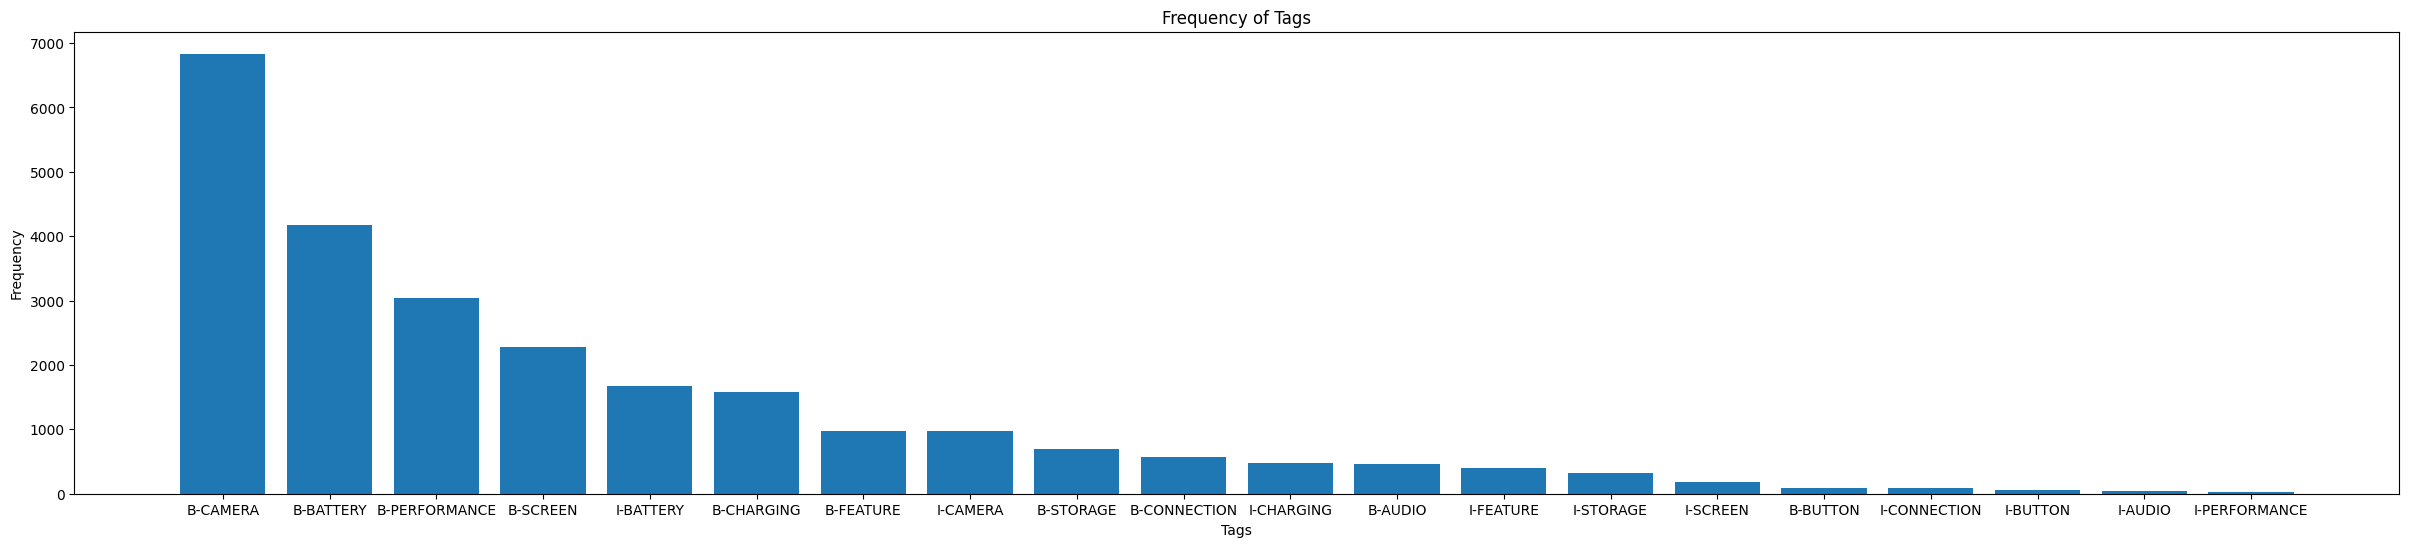

In [ ]:
label_counts = temp_df['labels'].value_counts()
plt.figure(figsize=(30, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of Tags')
plt.show()

In [ ]:
tag_df.to_csv('../datasets/tagged/dataset-iob-tag.csv', index=False)

## **Train**

In [ ]:
df = pd.read_csv('../datasets/tagged/iob-tag.csv')
df.head()

,sentence_id,words,labels
0,0,Best,O
1,0,phone,O
2,0,in,O
3,0,low,O
4,0,price,O


In [ ]:
TRAIN_ARGS = TrainingArguments('../model/review_NER',
	num_train_epochs=9,
	evaluation_strategy='epoch',
	save_strategy='epoch',
	load_best_model_at_end=True,
	push_to_hub=False
)

MODEL_NAME = 'dslim/distilbert-NER'
X = df[["sentence_id","words"]]
Y = df["labels"]
LABEL = ['O',
 'B-STORAGE',
 'B-PERFORMANCE',
 'B-BATTERY',
 'I-BATTERY',
 'B-CAMERA',
 'I-CAMERA',
 'B-CHARGING',
 'I-CHARGING',
 'I-STORAGE',
 'I-PERFORMANCE',
 'B-SCREEN',
 'I-SCREEN',
 'B-AUDIO',
 'B-FEATURE',
 'I-FEATURE',
 'B-CONNECTION',
 'I-CONNECTION',
 'B-BUTTON',
 'I-BUTTON',
 'I-AUDIO']
NUM_LABELS = len(LABEL)
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

In [ ]:
train, test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

trainer = Trainer(
	model=model,
	args=TRAIN_ARGS,
	train_dataset=train,
	eval_dataset=test,
	tokenizer=TOKENIZER,
	compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
results = trainer.evaluate()
print(f'Evaluation results: {results}')